## Análise 02 - Osciladores Harmônicos RC Defasamento

* Alejo P. Milar
* João Mário C. I. Lago

### Eletrônica III (2023.1 - T01)

<hr />

### Packages

In [29]:
%pip install -q scipy numpy quantiphy pandas control

Note: you may need to restart the kernel to use updated packages.


### Imports

In [30]:
from quantiphy import Quantity
import scipy as sci
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import control
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator
from quantiphy import Quantity
import cmath
from typing import Optional, List, Tuple

<hr />

### Utils

Definição de funções auxiliares para realização de alguns cálculos realizados durante a execução do trabalho

In [31]:
# Prints a given parameter with its unit and using multipliers
def print_param(name: str, value: float, unit: str = "") -> None:
	print(name + ": " + str(Quantity(value, unit)))


# Prints a given parameter with its unit and using multipliers
def print_param_dict(name: str, dict: dict) -> None:
	print(name, ":")
	for key in dict:
		print("	", key + ": " + str(Quantity(dict[key])))


# Converts a log value to a linear value
def log_2_linear(gain: float) -> float:
	return 10.0 ** (gain / 20.0)


# Converts a linear value to a log value
def linear_2_log(gain: float) -> float:
	return 20.0 * np.log10(gain)


def polar2string(x: tuple[float, float]) -> str:
	return str((x[0])) + ' < ' +str(np.rad2deg(x[1])) + '°'


def complex2polar_string(x):
	return polar2string((np.abs(x), np.angle(x)))


# Commercial EE values list
def get_EE_list(limit: int = 21, lower = 0, pack: Optional[ List[ float ] ] = None) -> List[ float ]:
	return [x * (10 ** i) for i in range(pack[1] if pack else lower, pack[0] if pack else limit) for x in [ 1.5e-12, 1.8e-12, 2.2e-12, 2.7e-12, 3.3e-12, 4.7e-12, 5.1e-12, 6.8e-12, 7.5e-12, 8.2e-12, 9.1e-12, 10e-12 ]]


def get_EE_limit_from_value(value: float) -> List[ int ]:
	order = np.floor(np.log10(value))
	return [ int(13 + order), int((13 + order) - 1) ]


# Find the best fit for the closest comercial value in the EE list
def round_to_commercial(value: float) -> float:
	EE: List[ float ] = get_EE_list()
	index: int = 0
	close: float = np.inf
	for i, val in enumerate(EE):
		diff = val - value
		if np.abs(diff) < close:
			close = np.abs(diff)
			index = i
	return EE[index]

def parse_ltspice_log(filename):
	f = open(filename, 'r')
	values = {}
	for line in f:
		if ":" in line and "=" in line:
			key = line.split(":")[0]
			try:
				values[key] = float(line.split("=")[1].split()[0].replace("\n", ""))
			except ValueError:
				continue
			if (key == "phase_active"):
				values[key] = -values[key]
	if ("phase_active" in values and "phase_passive" in values):
		values["phase_total"] = values["phase_active"] + values["phase_passive"]
	return values

# Prints a given parameter with its unit and using multipliers
def print_param_dict(name: str, dict: dict) -> None:
	print(name, ":")
	keys = sorted(dict.keys())
	for key in keys:
		units = ""
		# Check if voltage
		if (key[0].lower() == "v"):
			units = "V"
		# Check if gain
		elif ("gain" in key.lower()):
			units = "V/V"
		# Check if phase
		elif ("phase" in key.lower()):
			units = "°"
		# Check if freq
		elif ("freq" in key.lower()):
			units = "Hz"	

		print("	", key + ": " + str(Quantity(dict[key])), units)



# 1- Projetar um oscilador RC por defasagem de fase para uma frequência de 1400Hz apresentado na figura 1. Com ampop LM324.

### Cálculo do circuito sem fator de correção da impedância de entrada do bloco Alpha

In [32]:
# Oscilation frequency
fosc: float = 1400

# Angular velocity
wc: float = 2 * np.pi * fosc

# Searches for the best component fit
last_diff: int = 9999999
res: List[ float ] = []
for R in get_EE_list(17, 16):
	C = 1 / (2 * np.pi * np.sqrt(6) * R * fosc)
	RF = 29 * R
	C_commercial = round_to_commercial(C)
	RF_commercial = round_to_commercial(RF)
	total_diff = np.abs(C_commercial - C) + np.abs(RF_commercial - RF)
	RF_commercial = round_to_commercial(RF)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R, RF, C_commercial, RF_commercial ]

# Fetches saved value
[ C, R, RF, C_commercial, RF_commercial ] = res

print("------------------------------------------------------------------")
print("Parâmetros do circuito: ")
print_param("	- Ideal C", C, "F")
print_param("	- Ideal R", R, "Ω")
print_param("	- Ideal RF", RF, "Ω")
print()
print_param("	- Comercial C", C_commercial, "F")
print_param("	- Comercial R", R, "Ω")
print_param("	- Comercial RF", RF_commercial, "Ω")
print("------------------------------------------------------------------")
print("Parâmetros para o LTSpice: ")
print("	- Ideal:")
print(f"\t.param C={Quantity(C)} R={Quantity(R)} RF={Quantity(RF)}")
print("	- Comercial:")
print(f"\t.param C={Quantity(C_commercial)} R={Quantity(R)} RF={Quantity(RF_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C_commercial * R * np.sqrt(6))
FC_commercial_min = 1 / (np.pi * 2 * (C_commercial * 1.1) * (R * 1.05) * np.sqrt(6))
FC_commercial_max = 1 / (np.pi * 2 * (C_commercial * 0.9) * (R * 0.95) * np.sqrt(6))
print("------------------------------------------------------------------")
print_param("Valor de frequência comercial	  ", FC_commercial, "Hz")
print_param("Valor de frequência comercial (MIN)", FC_commercial_min, "Hz")
print_param("Valor de frequência comercial (MAX)", FC_commercial_max, "Hz")
print("------------------------------------------------------------------")

------------------------------------------------------------------
Parâmetros do circuito: 
	- Ideal C: 2.5784 nF
	- Ideal R: 18 kΩ
	- Ideal RF: 522 kΩ

	- Comercial C: 2.7 nF
	- Comercial R: 18 kΩ
	- Comercial RF: 510 kΩ
------------------------------------------------------------------
Parâmetros para o LTSpice: 
	- Ideal:
	.param C=2.5784n R=18k RF=522k
	- Comercial:
	.param C=2.7n R=18k RF=510k
------------------------------------------------------------------
Valor de frequência comercial	  : 1.3369 kHz
Valor de frequência comercial (MIN): 1.1575 kHz
Valor de frequência comercial (MAX): 1.5637 kHz
------------------------------------------------------------------


<hr />

Parâmetros do circuito: 
- C: 2.5784 nF
- R: 18 kΩ
- RF: 512 kΩ

# 2- Simule o circuito projetado

## Simulação
<p align="center">
<img src="analises/assets/script/2-Simule_o_circuito_projetado.png" width="75%">
</p>

## Grafico

<p align="center">
<img src="analises/assets/script/2-Simule_o_circuito_projetado_plot.png" width="75%">
</p>

## Analise

Como é possivel observar o ganho total do sistema não é suficiente para que ocorra uma oscilação natural isto pode ser observado na simulação a seguir onde os bolocos não são realimentados

## Simulação dos blocos separados

<p align="center">
<img src="analises/assets/script/2-Simule_o_circuito_projetado_separado.png" width="75%">
</p>

## Grafico dos blocos separados

<p align="center">
<img src="analises/assets/script/2-Simule_o_circuito_projetado_plot_separado.png" width="75%">
</p>

## Medição

In [34]:
print_param_dict("Blocos separados", parse_ltspice_log("analises/1/script/2-Simule o circuito projetado_separado.log"))

Blocos separados :
	 frequency_active: 1.4k Hz
	 frequency_passive: 1.4k Hz
	 gain_active: 28.403 V/V
	 gain_passive: 34.302m V/V
	 gain_total: 974.29m V/V
	 phase_active: -182.71 °
	 phase_passive: -179.87 °
	 phase_total: -362.58 °
	 vin_active: 800m V
	 vin_passive: 22.723 V
	 vout_active: 22.723 V
	 vout_passive: 779.43m V


### Analise

O ganho total do sistema é aproximadamente 0.97 o que cria uma realimentação negativa do sinal causando o amortecimento do mesmo até 0

# 3- Caso tenha ocorrido saturação da tensão de saída do ampop, reduza o ganho do bloco amplificador o máximo que puder, para isto varie o potenciômetro.

## Simulação

<p align="center">
<img src="analises/assets/script/3-Ajuste_potenciometro.png" width="75%">
</p>

## Grafico

<p align="center">
<img src="analises/assets/script/3-Ajuste_potenciometro_plot.png" width="75%">
</p>

## Medição

In [35]:
print_param_dict("Blocos separados", parse_ltspice_log("analises/1/script/3-ajuste_potenciometro.log"))

Blocos separados :
	 frequency_active: 1.5161k Hz
	 frequency_passive: 1.5162k Hz
	 gain_active: 44.928 V/V
	 gain_passive: 22.258m V/V
	 gain_total: 1 V/V
	 phase_active: -185.27 °
	 phase_passive: -185.28 °
	 phase_total: -370.55 °
	 vin_active: 382.55m V
	 vin_passive: 17.188 V
	 vout_active: 17.188 V
	 vout_passive: 382.55m V


## Analise

Existe um desvio de 129Hz aproximadamente

# 5- Analise o funcionamento e os critérios de Brakhausen para: (Utilize os circuitos das figuras 2 e 3)

## Para a frequência projetada

### Simulação

**Circuito**

<p align="center">
<img src="analises/assets/script/5-analise_Brakhausen_1400Hz_A_B.png" width="75%">
</p>

<div align="center">
<p style="text-align:left;">
    <b> A-B </b>
    <span style="position:absolute; left:50%;">
        <b> B-A </b>
    </span>
</p>
<img src="analises/assets/script/5-analise_Brakhausen_1400Hz_A_B_zoom.png" width="45%">
<img src="analises/assets/script/5-analise_Brakhausen_1400Hz_B_A_zoom.png" width="45%"> 
</div>

### Grafico

<div align="center">
<p style="text-align:left;">
    <b> A-B </b>
    <span style="position:absolute; left:50%;">
        <b> B-A </b>
    </span>
</p>
<img src="analises/assets/script/5-analise_Brakhausen_1400Hz_A_B_plot.png" width="45%">
<img src="analises/assets/script/5-analise_Brakhausen_1400Hz_B_A_plot.png" width="45%"> 
</div>

### Medição

In [36]:
print_param_dict("Blocos A-B", parse_ltspice_log("analises/1/script/5-analise_Brakhausen_1400Hz_A_B.log"))
print_param_dict("Blocos B-A", parse_ltspice_log("analises/1/script/5-analise_Brakhausen_1400Hz_B_A.log"))

Blocos A-B :
	 frequency_active: 1.4k Hz
	 frequency_passive: 1.4k Hz
	 gain_active: 44.951 V/V
	 gain_passive: 34.136m V/V
	 gain_total: 1.5344 V/V
	 phase_active: 175.79 °
	 phase_passive: 180.16 °
	 phase_total: 355.95 °
	 vin_active: 600m V
	 vin_passive: 26.97 V
	 vout_active: 26.97 V
	 vout_passive: 920.66m V
Blocos B-A :
	 frequency_active: 1.4k Hz
	 frequency_passive: 1.4k Hz
	 gain_active: 44.935 V/V
	 gain_passive: 18.849m V/V
	 gain_total: 846.98m V/V
	 phase_active: -184.76 °
	 phase_passive: -190.15 °
	 phase_total: -374.9 °
	 vin_active: 452.37m V
	 vin_passive: 24 V
	 vout_active: 20.327 V
	 vout_passive: 452.37m V


### Analise

Nenhum dos dois circuitos cumprem os criterios de Brakhausen, quando o bloco passivo é conectado no ativo a fase é um pouco maior que 360° e o ganho é 50% acima de 1 V/V, já quando o ativo é conectado no passivo a fase é um pouco menor 360° e o ganho diminui bastante (0.84 V/V)

## Para a frequencia natural (1.5161kHz)

### Simulação

**Circuito**

<p align="center">
<img src="analises/assets/script/5-analise_Brakhausen_1516Hz_A_B.png" width="75%">
</p>

<div align="center">
<p style="text-align:left;">
    <b> A-B </b>
    <span style="position:absolute; left:50%;">
        <b> B-A </b>
    </span>
</p>
<img src="analises/assets/script/5-analise_Brakhausen_1516Hz_A_B_zoom.png" width="45%">
<img src="analises/assets/script/5-analise_Brakhausen_1516Hz_B_A_zoom.png" width="45%"> 
</div>

### Grafico

<div align="center">
<p style="text-align:left;">
    <b> A-B </b>
    <span style="position:absolute; left:50%;">
        <b> B-A </b>
    </span>
</p>
<img src="analises/assets/script/5-analise_Brakhausen_1516Hz_A_B_plot.png" width="45%">
<img src="analises/assets/script/5-analise_Brakhausen_1516Hz_B_A_plot.png" width="45%"> 
</div>

### Medição

In [37]:
print("Bloco A: Ativo")
print("Bloco B: Passivo")
print()

print_param_dict("Blocos A-B", parse_ltspice_log("analises/1/script/5-analise_Brakhausen_1516Hz_A_B.log"))
print_param_dict("Blocos B-A", parse_ltspice_log("analises/1/script/5-analise_Brakhausen_1516Hz_B_A.log"))

Bloco A: Ativo
Bloco B: Passivo

Blocos A-B :
	 frequency_active: 1.5161k Hz
	 frequency_passive: 1.5161k Hz
	 gain_active: 44.926 V/V
	 gain_passive: 40.104m V/V
	 gain_total: 1.8017 V/V
	 phase_active: -184.54 °
	 phase_passive: -175.24 °
	 phase_total: -359.78 °
	 vin_active: 600m V
	 vin_passive: 26.956 V
	 vout_active: 26.956 V
	 vout_passive: 1.081 V
Blocos B-A :
	 frequency_active: 1.516k Hz
	 frequency_passive: 1.516k Hz
	 gain_active: 44.909 V/V
	 gain_passive: 22.367m V/V
	 gain_total: 1.0045 V/V
	 phase_active: 175.01 °
	 phase_passive: 174.15 °
	 phase_total: 349.15 °
	 vin_active: 536.81m V
	 vin_passive: 24 V
	 vout_active: 24.108 V
	 vout_passive: 536.81m V


### Analise

Quando o bloco ativo é conectado no passivo para a frequencia natural o oscilador cumpre os criterios de Brakhausen para a fase (360°), porém para ganho é relativemnte maior do que necessario para cumprir o criterio isso pode explicar a leve saturação na oscilação.
Já quando o ativo é conectado no passivo existe uma desviação do criterio de Brakhausen, a causa dessa desviação vai ser abordada no seguinte item



# 6- Verifique via simulação a influência das impedâncias de entrada e saída dos blocos A e B.

Sera analisado a influencia do bloco A no bloco B porque segundo a simulação anterior o bloco A está influenciando o bloco B


## Simulação

**Circuito**

<p align="center">
<img src="analises/assets/script/6-analise_impedancia_1516Hz_B_A.png" width="75%">
</p>

<div align="center">
<p style="text-align:left;">
    <b> B-A </b>
    <span style="position:absolute; left:50%;">
        <b> B </b>
    </span>
</p>
<img src="analises/assets/script/6-analise_impedancia_1516Hz_B_A_zoom.png" width="45%">
<img src="analises/assets/script/6-analise_impedancia_1516Hz_B_zoom.png" width="45%"> 
</div>

## Grafico

<div align="center">
<p style="text-align:left;">
    <b> B-A </b>
    <span style="position:absolute; left:50%;">
        <b> B </b>
    </span>
</p>
<img src="analises/assets/script/6-analise_impedancia_1516Hz_B_A_plot.png" width="45%">
<img src="analises/assets/script/6-analise_impedancia_1516Hz_B_plot.png" width="45%"> 
</div>

## Medição

In [38]:
print("Bloco A: Ativo")
print("Bloco B: Passivo")
print()

print_param_dict("Blocos B-A", parse_ltspice_log("analises/1/script/6-analise_impedancia_1516Hz_B_A.log"))
print_param_dict("Blocos B", parse_ltspice_log("analises/1/script/6-analise_impedancia_1516Hz_B.log"))

Bloco A: Ativo
Bloco B: Passivo

Blocos B-A :
	 frequency_active: 1.516k Hz
	 frequency_passive: 1.516k Hz
	 gain_active: 44.909 V/V
	 gain_passive: 22.367m V/V
	 gain_total: 1.0045 V/V
	 phase_active: 175.01 °
	 phase_passive: 174.15 °
	 phase_total: 349.15 °
	 vin_active: 536.81m V
	 vin_passive: 24 V
	 vout_active: 24.108 V
	 vout_passive: 536.81m V
Blocos B :
	 frequency_passive: 1.516k Hz
	 gain_passive: 40.546m V/V
	 phase_passive: 184.65 °
	 vin_active: 0 V
	 vin_passive: 24 V
	 vout_active: 0 V
	 vout_passive: 973.09m V


## Analise

Ao colocar o bloco A na saida do bloco B existe uma dimição do ganho passivo como também uma alteração na fase, isso quer dizer que a impedancia de entrada do bloco A esta afetando o bloco B

# 7- Calcule a impedância de entrada e de saída dos blocos A e B

As impedâncias são cálculadas do ponto de vista dos blocos acoplados, ou seja a impedância vista do bloco alpha leva em consideração as mudanças geradas pelo acoplamentio de impedâncias do bloco beta e vice versa.

A busca das impedâncias é feita buscando a impedância equivalente do bloco quando analisado de um certo ponto de vista.

As impedâncias foram calculadas utilizando como base os valores reais do circuito montado ná prática.

### Calculo das impedâncias do bloco alpha

A impedância de entrada do bloco alpha é dada pelo próprio R que existe na entrada do sinal no amplificador, no circuito implementado seu valor é de 35.97 kΩ.
A impedância de saída do bloco alpha é dada pela própria impedância de saída interna do ampop utilizado, no case este valor foi obtido a partir do seguinte fórum do fabricante.

Acesso em maio de 2023

https://e2e.ti.com/support/amplifiers-group/amplifiers/f/amplifiers-forum/740362/lm324-what-is-the-output-impedance

* Entrada: R entrada amplificador = 35.97 kΩ

* Saida: R_ampop = Na casa dos 610 Ω

### Cálculo das impedâncias do bloco beta

O cálculo da impedância do bloco beta é feito encontrando a impedância equivalente do bloco beta adicionando junto a influência do bloco alpha que afeta com sua impedância de entrada e saída, pois no caso do cálculo da impedância de entrada do bloco beta, deve-se levar em consideração o R de entrada do bloco alpha e para o cálculo da impedância de saída devemos levar em consideração a impedância de saída do bloco alpha

In [39]:
# Impedances

def filter_input_impedance(freq: float, r1, r2, r3, c1, c2, c3):
	zr1 = zr(r1, freq)
	zr2 = zr(r2, freq)
	zr3 = zr(r3, freq)
	zc1 = zc(c1, freq)
	zc2 = zc(c2, freq)
	zc3 = zc(c3, freq)
	return series(zc1, parallel(zr1, series(zc2, parallel(zr2, series(zc3, zr3)))))

def filter_output_impedance(freq: float, r1, r2, r3, c1, c2, c3, r_amp):
	zr1 = zr(r1, freq)
	zr2 = zr(r2, freq)
	zr3 = zr(r3, freq)
	zc1 = zc(c1, freq)
	zc2 = zc(c2, freq)
	zc3 = zc(c3, freq)
	return parallel(zr3, series(zc3, parallel(zr2, series(zc2, parallel(zr1, series(zc1, r_amp))))))

print("Impedância de entrada do bloco beta: ")
print(complex2polar_string(filter_input_impedance(1400, 13.43e3, 17.97e3, parallel(35.82, 35.97), 2.67e-9, 2.81e-9, 2.75e-9)) + " Ω\n")
print("Impedância de saída do bloco beta: ")
print(complex2polar_string(filter_output_impedance(1400, 13.43e3, 17.97e3, parallel(35.82, 35.97), 2.67e-9, 2.81e-9, 2.75e-9, 610)) + " Ω")


Impedância de entrada do bloco beta: 
46871.67344249547 < -75.50886611809987° Ω

Impedância de saída do bloco beta: 
17.94542968501985 < -0.020196306305621827° Ω


## Analise

A impedancia de entrada do circuito ativo é igual a R3 e como R3 é igual a R6, na visão do circuito passivo o ultimo resistor (R6) acaba sendo o paralelo entre R3 e R6 o que é igual a $ \frac{R6}{2}$

# 8- Altere o valor de R10 para que o circuito oscile na frequência desejada. Explique

## Calculos

Como na visão do circuito passivo a impedancia do ultimo resistor é igual ao paralelo de R3 e R6 pode ser usando o dobro do valor nos dois resistores resultando para a visão do circuito passivo que R6 está no valor calculado. E o valor de Rf tem que ser recalculado para o novo valor de R3

**Novos valores**

Parâmetros do circuito: 
- C: 2.5784 nF
- R: 18 kΩ
- RD: 35.999 kΩ
- RF: 1024 kΩ


### Cálculo do circuito com correção da impedância de entrada do bloco Alpha

In [53]:
# Oscilation frequency
fosc: float = 1400

# Angular velocity
wc: float = 2 * np.pi * fosc

# Searches for the best component fit
last_diff: int = 9999999
res: List[ float ] = []
for R in get_EE_list(17, 16):
	C = 1 / (2 * np.pi * np.sqrt(6) * R * fosc)
	RD = 2 * R
	RF = 29 * R
	C_commercial = round_to_commercial(C)
	RD_commercial = round_to_commercial(RD)
	RF_commercial = round_to_commercial(RF)
	total_diff = np.abs(C_commercial - C) + np.abs(RF_commercial - RF)
	RF = 2 * RF
	RF_commercial = round_to_commercial(RF)
	if (total_diff < last_diff):
		last_diff = total_diff
		res = [ C, R, RD, RF, C_commercial, RD_commercial, RF_commercial ]

# Fetches saved value
[ C, R, RD, RF, C_commercial, RD_commercial, RF_commercial ] = res

print("------------------------------------------------------------------")
print("Parâmetros do circuito: ")
print_param("	- Ideal C", C, "F")
print_param("	- Ideal R", R, "Ω")
print_param("	- Ideal RD", RD, "Ω")
print_param("	- Ideal RF", RF, "Ω")
print()
print_param("	- Comercial C", C_commercial, "F")
print_param("	- Comercial R", R, "Ω")
print_param("	- Comercial RD", RD_commercial, "Ω")
print_param("	- Comercial RF", RF_commercial, "Ω")
print("------------------------------------------------------------------")
print("Parâmetros para o LTSpice: ")
print("	- Ideal:")
print(f"\t.param C={Quantity(C)} R={Quantity(R)} RD={Quantity(RD)} RF={Quantity(RF)}")
print("	- Comercial:")
print(f"\t.param C={Quantity(C_commercial)} R={Quantity(R)} RD={Quantity(RD_commercial)} RF={Quantity(RF_commercial)}")

FC_commercial = 1 / (np.pi * 2 * C_commercial * R * np.sqrt(6))
FC_commercial_min = 1 / (np.pi * 2 * (C_commercial * 1.1) * (R * 1.05) * np.sqrt(6))
FC_commercial_max = 1 / (np.pi * 2 * (C_commercial * 0.9) * (R * 0.95) * np.sqrt(6))
print("------------------------------------------------------------------")
print_param("Valor de frequência comercial	  ", FC_commercial, "Hz")
print_param("Valor de frequência comercial (MIN)", FC_commercial_min, "Hz")
print_param("Valor de frequência comercial (MAX)", FC_commercial_max, "Hz")
print("------------------------------------------------------------------")

------------------------------------------------------------------
Parâmetros do circuito: 
	- Ideal C: 2.5784 nF
	- Ideal R: 18 kΩ
	- Ideal RD: 36 kΩ
	- Ideal RF: 1.044 MΩ

	- Comercial C: 2.7 nF
	- Comercial R: 18 kΩ
	- Comercial RD: 33 kΩ
	- Comercial RF: 1 MΩ
------------------------------------------------------------------
Parâmetros para o LTSpice: 
	- Ideal:
	.param C=2.5784n R=18k RD=36k RF=1.044M
	- Comercial:
	.param C=2.7n R=18k RD=33k RF=1M
------------------------------------------------------------------
Valor de frequência comercial	  : 1.3369 kHz
Valor de frequência comercial (MIN): 1.1575 kHz
Valor de frequência comercial (MAX): 1.5637 kHz
------------------------------------------------------------------


## Simulação

<p align="center">
<img src="analises/assets/script/8-novo_valor_R3.png" width="75%">
</p>

## Grafico

<p align="center">
<img src="analises/assets/script/8-novo_valor_R3_plot.png" width="75%">
</p>


## Medidas

In [40]:
print_param_dict("Alteração em R3", parse_ltspice_log("analises/1/script/8-novo_valor_R3.log"))

Alteração em R3 :
	 frequency_active: 1.3447k Hz
	 frequency_passive: 1.3447k Hz
	 gain_active: 31.163 V/V
	 gain_passive: 32.089m V/V
	 gain_total: 1 V/V
	 phase_active: 175.97 °
	 phase_passive: 175.98 °
	 phase_total: 351.95 °
	 vin_active: 226.17m V
	 vin_passive: 7.0481 V
	 vout_active: 7.0481 V
	 vout_passive: 226.17m V


## Analise

O ajuste de R3 permitiu maior precissão na frequencia de oscilação como no ganho (o potenciometro de feedback precisou de 100k em vez de 100k)

## Otimização pelas não idealidades do ampop

### Modelagem de um filtro passa alta represetando o filtro usado no oscilador

In [41]:
def zc(c: float, freq: float):
    xc = 1 / (2 * np.pi * freq * c)
    return 0 + (xc / 1j)

def zr(r: float, freq: float):
    return r + 0j

def parallel(z1, z2):
    return (z1 * z2) / (z1 + z2)

def series(z1, z2):
    return z1 + z2

# Gain of the 1° RC filter
def kn1(zr1, zr2, zr3, zc1, zc2, zc3):
    zeq = parallel(zr1, series(zc2, parallel(zr2, series(zc3, zr3))))
    return (zeq / (series(zc1, zeq)))

# Gain of the 2° RC filter
def kn2(zr1, zr2, zr3, zc1, zc2, zc3):
    zeq = parallel(zr2, series(zc3, zr3))
    return (zeq / (series(zc2, zeq)))

# Gain of the 3° RC filter
def kn3(zr1, zr2, zr3, zc1, zc2, zc3):
    return (zr3 / series(zc3, zr3))

def net(zr1, zr2, zr3, zc1, zc2, zc3):
    k1 = kn1(zr1, zr2, zr3, zc1, zc2, zc3)
    k2 = kn2(zr1, zr2, zr3, zc1, zc2, zc3)
    k3 = kn3(zr1, zr2, zr3, zc1, zc2, zc3)
    k = (k1 * k2 * k3)
    return k

def filter_model(freq: float, r1, r2, r3, c1, c2, c3):
    zr1 = zr(r1, freq)
    zr2 = zr(r2, freq)
    zr3 = zr(r3, freq)
    zc1 = zc(c1, freq)
    zc2 = zc(c2, freq)
    zc3 = zc(c3, freq)
    return net(zr1, zr2, zr3, zc1, zc2, zc3)

# Simple test for filter
print(complex2polar_string(filter_model(1400, 18e3, 18e3, 18e3, 2.5784e-9, 2.5784e-9, 2.5784e-9)))

0.034483797972785696 < 179.99915397306222°


### Modelando o amplificador operacional


In [42]:
df = pd.read_csv("analises/open_loop/example/open_loop_gain.csv", index_col="frequency")
df.reset_index().info()

df.phase = -df.phase

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64511 entries, 0 to 64510
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frequency  64511 non-null  float64
 1   gain       64511 non-null  float64
 2   phase      64511 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


### Criação do modelo

O comportamento em malha aberta de um amplificador operacional (op-amp) é semelhante a um amplificador ideal com um filtro passa-baixa na saída. Portanto, um modelo simplificado de um op-amp LM324 pode ser representado como um amplificador operacional ideal com um filtro RC na saída.

<img src="analises/assets/lm324_model.png">

$$
w0 = \frac{1}{r * c}
$$

$$
\frac{-gain}{\frac{s}{w0} + 1} 
$$

In [43]:
# Create the transfer function of a theoretical low pass filter
def get_n1_low_pass_filter(r: float, c: float, gain: float) -> control.TransferFunction:
	w0 = 1 / (r * c)

	num = [0, -gain]
	den = [1 / w0, 1]
	return control.TransferFunction(num, den)

def get_opamp_model_output(r: float, c: float, open_loop_gain: float, frequency):
	return get_n1_low_pass_filter(r, c, open_loop_gain).frequency_response(2 * np.pi * frequency)


### Plot de exemplo do modelo do ampop

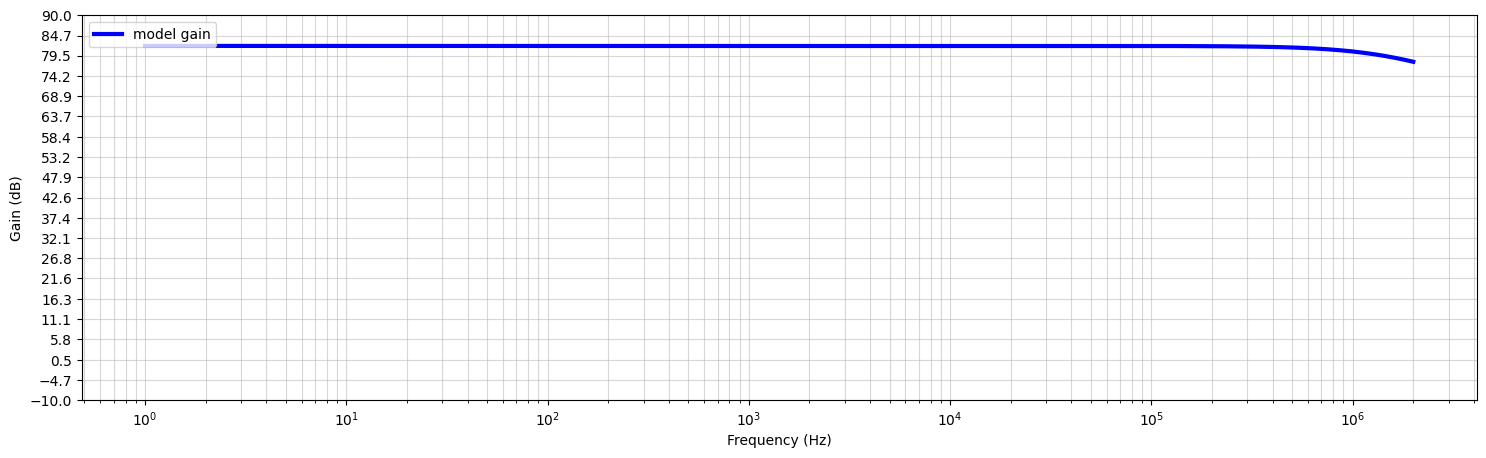

In [44]:

mag, phase, omega = get_opamp_model_output(100, 1e-9, log_2_linear(82), df.index)
fig, ax = plt.subplots(figsize = (18, 5))

# plot gain
ax.plot(
	df.index,
	linear_2_log(mag),
	label = "model gain",
	color = "b",
	linewidth = 3.0
)

# general ax configuration 
ax.set_xscale('log', base = 10)
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks(np.round(np.linspace(-10, 90, 20), 1))

### Ajustar o modelo com os dados da simulação

Medir o ganho em malha aberta por meio da análise AC pode ser desafiador devido à possibilidade de erros gerados pelo desvio de corrente contínua (DC offset).
Para resolver isso, podemos utilizar o método de Michael Tian, como demonstrado neste [video](https://www.youtube.com/watch?v=bXbDa9nglZI) e explicado com mais detalhes neste [artigo](https://kenkundert.com/docs/cd2001-01.pdf).

Simulação:

<img src="analises/assets/lm324_open_loop_simulation.png">

#### Ajuste de curva

Ao utilizar a função de ajuste de curva do SciPy, é importante observar que ela só pode ter um valor de ponto flutuante como saída. Isso significa que apenas o ganho ou a fase podem ser ajustados, mas não ambos simultaneamente.

In [45]:
# Opamp RC model with gain as independent variable, this function is for scipy curve fit
def filter_model_gain(x, r, c, open_loop_gain):
    c = c
    r = r
    open_loop_gain = abs(open_loop_gain)
    mag, phase, omega = get_opamp_model_output(r, c, log_2_linear(open_loop_gain), x)
    return mag

# Opamp RC model with gain as independent variable, this function is for scipy curve fit
def filter_model_phase(x, r, c, open_loop_gain):
    c = abs(c)
    r = abs(r)
    open_loop_gain = abs(open_loop_gain)
    mag, phase, omega = get_opamp_model_output(r, c, log_2_linear(open_loop_gain), x)
    return np.rad2deg(phase)

popt, pcov = curve_fit(filter_model_gain, 
                        df.index,
                        log_2_linear(df.gain),
                    	[900, 50e-9, 80],
                        bounds=(0, [100e3, 10e-6, 200]))

r = abs(popt[0])
c = abs(popt[1])
open_loop_gain = abs(popt[2])


print("Lm324 model")
print_param("R", popt[0], "R")
print_param("C", abs(popt[1]), "F")
print_param("open_loop_gain", popt[2], "dB")



Lm324 model
R: 25.293 R
C: 436.89 nF
open_loop_gain: 40.099 dB


#### Plot de resultados

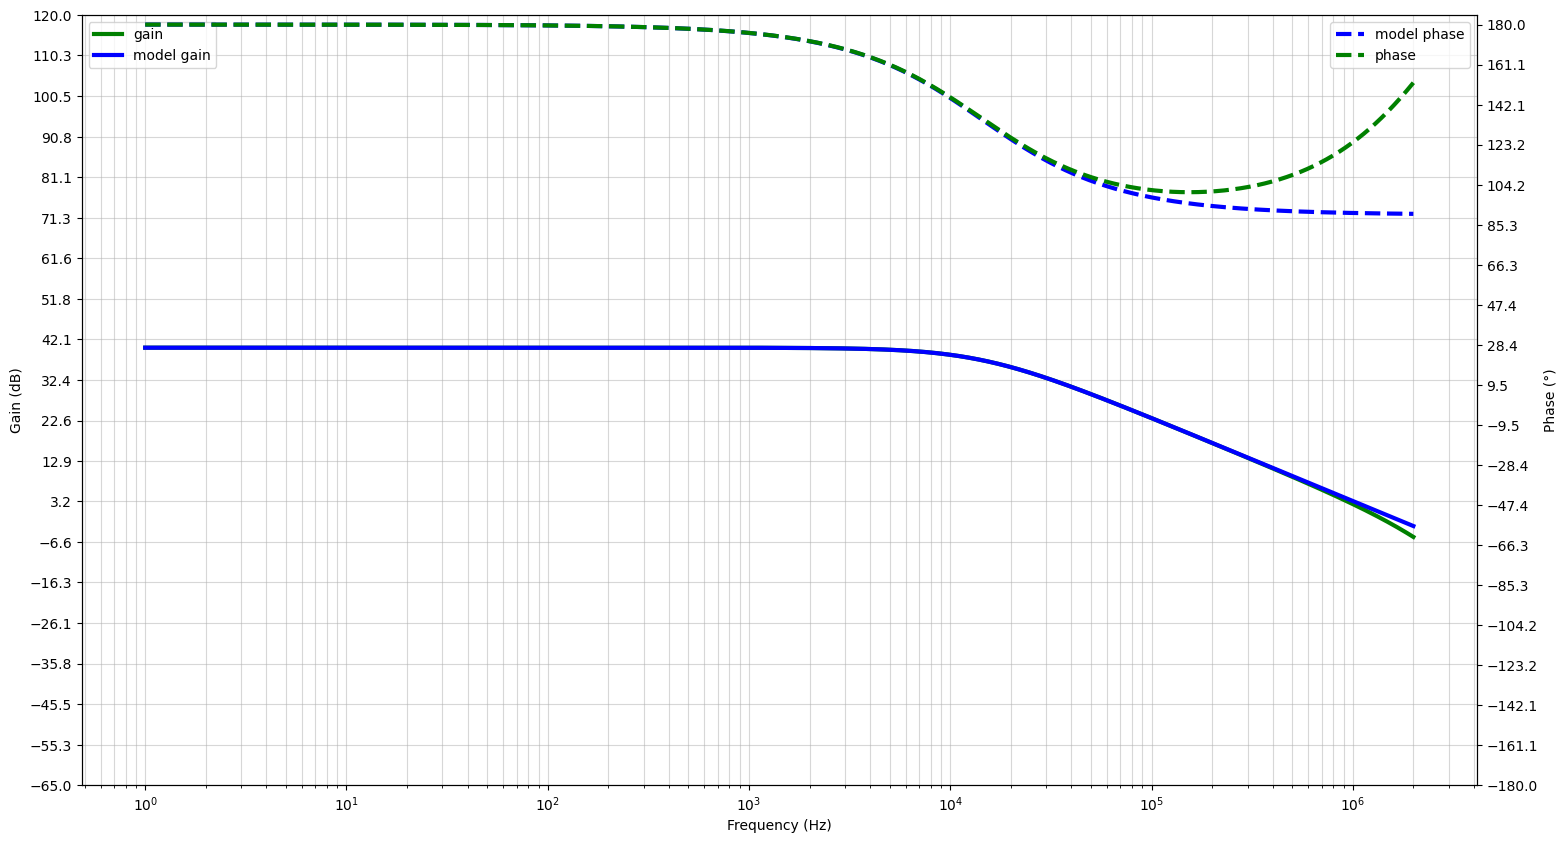

In [46]:
fig, ax = plt.subplots(figsize = (18, 10))

mag, phase, omega = get_opamp_model_output(r, c, log_2_linear(open_loop_gain), df.index)

df.plot(
	ax = ax,
	y = ["gain"],
	color = ["g"],
	lw = 3.0,
)

ax.plot(
	df.index,
	linear_2_log(mag),
	label = "model gain",
	color = "b",
	linewidth = 3.0
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	df.index,
	np.rad2deg(np.array(phase)),
	label = "model phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

df.plot(
	ax = ax2,
	y = ["phase"],
	style = ["--"],
	color = ["g"],
	lw = 3.0
)


# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks(np.round(np.linspace(-65, 120, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)

### Modelando o ampop inversor

**Utilizando analise de malha**

$ V_+ = V_{in} $

Divisor de tensão entre $ V_{out} $ e $ V_- $

$ V_- = \frac{Vout * R1}{Rf + R1 + R_{out}} $

Pelo modelo do ampop

$ V_{out} = Av * (V_+ - V_-) $

Substituindo

$ V_{out} = Av * (V_{in} - \frac{Vout * R1}{Rf + R1 + R_{out}}) $

Distribuindo Av

$ V_{out} = Av * V_{in} - \frac{Vout * R1 * Av}{Rf + R1 + R_{out}} $

Isolando $ V_{out} $

$ V_{out} - Av * V_{in} =  - \frac{Vout * R1 * Av}{Rf + R1 + R_{out}} $

$ V_{in} = V_{out} * (\frac{1}{Av} + \frac{R1}{Rf + R1 + R_{out}}) $

Isolando $ R_{out} $ da fração

$ V_{in} = V_{out} * (\frac{1}{Av} + \frac{1}{\frac{R1 + Rf}{R1} + \frac{R_{out}}{R1}}) $

Como $ \frac{R1 + Rf}{R1} $ é igual ao ganho teorico $ G $ pode ser substituido $ \frac{R1 + Rf}{R1} $ por $ G $ 

$ V_{in} = V_{out} * (\frac{1}{Av} + \frac{1}{G + \frac{R_{out}}{R1}}) $

$ \frac{1}{G_{real}} = (\frac{1}{Av} + \frac{1}{G + \frac{R_{out}}{R1}}) $

$ G_{real} = (\frac{1}{Av} + \frac{1}{G + \frac{R_{out}}{R1}})^{-1} $

In [47]:
def inverting_opamp_model(r1, rf, r_opamp, c_opamp, open_loop_gain, frequency):
	# Get intrinsic gain and phase of the opamp
	Aov_mag, Aov_phase, omega = get_opamp_model_output(r_opamp, c_opamp, open_loop_gain, frequency)

	# Classic inverting amplifier gain with opamp
	G_abs = ((r1 + rf) / r1)
	G_real_abs = 1 / ((1 / G_abs) + (1 / Aov_mag))
	G_real_phase = Aov_phase
	
	return G_real_abs * np.exp(1j * G_real_phase)


#### Example using a inverting amplifier with gain 2 V/V

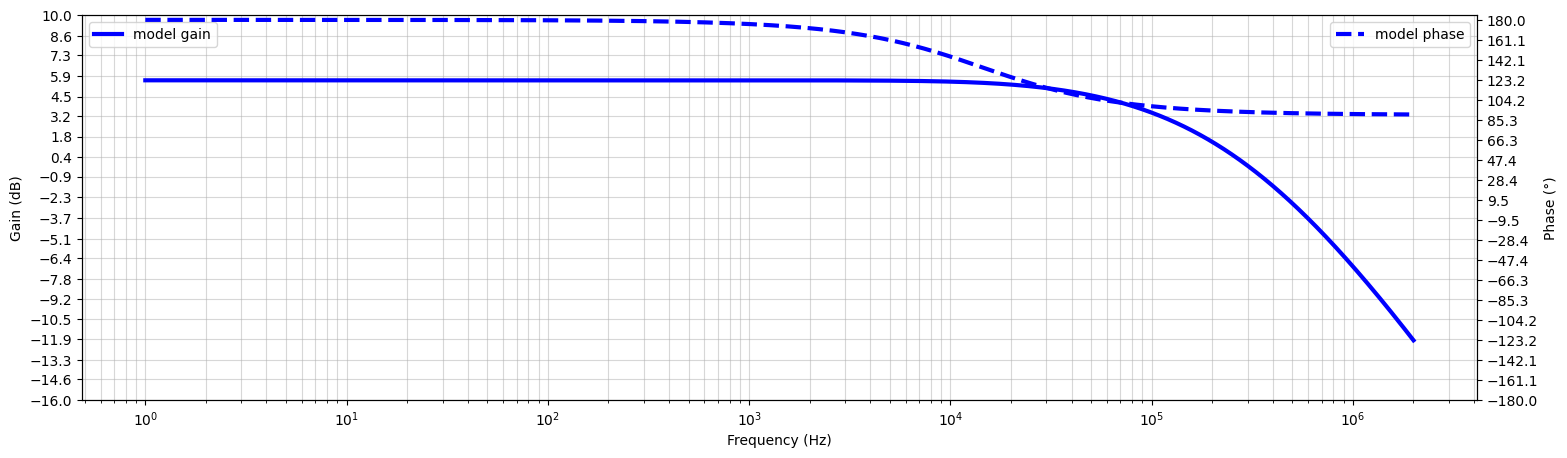

In [48]:
fig, ax = plt.subplots(figsize = (18, 5))

g_real = inverting_opamp_model(10e3, 10e3, r, c, open_loop_gain, df.index)

ax.plot(
	df.index,
	linear_2_log(np.abs(g_real)),
	label = "model gain",
	color = "b",
	linewidth = 3.0
)

# plot phases
ax2 = ax.twinx()

ax2.plot(
	df.index,
	np.rad2deg(np.angle(g_real)),
	label = "model phase",
	color = "b",
	linestyle = "--",
	linewidth = 3.0
)

# general ax configuration 
ax.legend(loc="upper left")
ax.grid(visible = True, which = "both", axis = "both", alpha = 0.5)
ax.set_ylabel("Gain (dB)")
ax.set_xlabel("Frequency (Hz)")
ax.set_yticks(np.round(np.linspace(-16, 10, 20), 1))

ax2.legend()
ax2.set_ylabel("Phase (°)")
ax2.set_yticks(np.round(np.linspace(-180, 180, 20), 1))

# configure X axis
ax.set_xscale('log', base = 10)
ax.xaxis.set_major_locator(LogLocator(base = 10.0, numticks = 15))
ax.xaxis.set_minor_locator(
	LogLocator(
		base = 10.0, subs = np.arange(0.1, 1.0, 0.1), numticks = 150
	)
)

# Otimizando o oscilador

### Modelo do oscilador

O critério de Barkhausen é um conjunto de condições que devem ser satisfeitas para que um oscilador mantenha as oscilações. Existem duas condições:

- O ganho em malha fechada ao redor do circuito de realimentação deve ser igual a 1 na frequência de oscilação.
- O deslocamento de fase ao redor do circuito de realimentação deve ser um múltiplo inteiro de 360 graus.

Em outras palavras, o sinal de realimentação deve estar em fase com o sinal de entrada e sua magnitude deve ser igual ou maior que o sinal de entrada para que a oscilação seja sustentada.

In [49]:
def oscillator_total_gain(frequency, opamp: dict, filter: dict):
	k_opamp = inverting_opamp_model(opamp["r1"], opamp["rf"], opamp["r_opamp"], opamp["c_opamp"], opamp["open_loop_gain"], frequency)
	k_filter = filter_model(frequency, filter["r1"], filter["r2"], filter["r3"], filter["c1"], filter["c2"], filter["c3"])
	# the total gain of an oscilator is the opamp gain vs passive filter gain 
	return k_opamp * k_filter
lm324 = {
    "r1":1e3,
	"rf": 10e3,
	"r_opamp": r,
	"c_opamp": c,
	"open_loop_gain": open_loop_gain,
	}
filter = {
    "r1": 18e3,
	"r2": 18e3,
	"r3": 18e3,
	"c1": 2.5784e-9,
	"c2": 2.5784e-9,
	"c3": 2.5784e-9,
	}
print("Total gain: ", complex2polar_string(oscillator_total_gain(1400, lm324, filter)))

Total gain:  [0.2973638] < [-5.55270175]°


### Usando o scipy para encontrar o critério de Barkhausen

In [50]:
def total_phase_to_optimize(x: np.ndarray, opamp: dict, filter: dict, frequency) -> float:
	filter["r1"] = x
	# The optimizer seems to reduce de error if the capacitor is in nF instead of F
	#filter["c1"] = filter["c2"] = filter["c3"] = x[1] / 1e9
	return np.abs(np.angle(oscillator_total_gain(frequency, opamp, filter)))


lm324 = {
	# input resistor 
    "r1":10e3,
    # feedback resistor 
	"rf": 10e3,
	# resistor of the RC output filter model
	"r_opamp": r,
	# capacitor of the RC output filter model
	"c_opamp": c,
	# open loop gian of the RC output filter model
	"open_loop_gain": open_loop_gain,
	}

filter = {
    "r1": 18e3,
	"r2": 18e3,
	"r3": parallel(36e3, 36e3),
	"c1": 2.5784e-9,
	"c2": 2.5784e-9,
	"c3": 2.5784e-9,
	}

frequency_target = 1400

res = sci.optimize.minimize_scalar(total_phase_to_optimize, 50e3, args=(lm324, filter, frequency_target), bounds=(100, 100e3))



print("Passive components to archive the phase of the Barkhausen criteria")
print_param("final phase", np.rad2deg(total_phase_to_optimize(res.x, lm324, filter, frequency_target)), "°")
print_param_dict("filter", filter)
print_param_dict("lm324", lm324)

Passive components to archive the phase of the Barkhausen criteria
final phase: 158.91n°
filter :
	 c1: 2.5784n 
	 c2: 2.5784n 
	 c3: 2.5784n 
	 r1: 14.189k 
	 r2: 18k 
	 r3: 18k 
lm324 :
	 c_opamp: 436.89n 
	 open_loop_gain: 40.099 V/V
	 r1: 10k 
	 r_opamp: 25.293 
	 rf: 10k 


### Otimizando para o ganho

In [51]:
def total_gain_to_optimize(x: np.ndarray, wanted_gain, opamp: dict, filter: dict, frequency) -> float:
	lm324["rf"] = x
	#print(np.abs(oscillator_total_gain(frequency, opamp, filter) - wanted_gain) )
	return np.abs((oscillator_total_gain(frequency, opamp, filter) - wanted_gain)) 

filter["r3"] = filter["r2"] * 2
lm324["r1"] = filter["r3"]

res = sci.optimize.minimize_scalar(total_gain_to_optimize, 100e3, args=(1, lm324, filter, frequency_target), bounds=(51e3, 100e6))

print("Passive components to archive the gain of the Barkhausen criteria")
print_param("final gain", total_gain_to_optimize(res.x, 0, lm324, filter, frequency_target), "V/V")
print_param("error", 100 * ((1 / ((total_gain_to_optimize(res.x, 0, lm324, filter, frequency_target)))) -1), "%")
print_param_dict("filter", filter)
print_param_dict("lm324", lm324)

Passive components to archive the gain of the Barkhausen criteria
final gain: 977.4 mV/V
error: 2.3125%
filter :
	 c1: 2.5784n 
	 c2: 2.5784n 
	 c3: 2.5784n 
	 r1: 14.189k 
	 r2: 18k 
	 r3: 36k 
lm324 :
	 c_opamp: 436.89n 
	 open_loop_gain: 40.099 V/V
	 r1: 36k 
	 r_opamp: 25.293 
	 rf: 1.3927M 


#### Resumo

Foi modelado o ampop como um ganho ideal com um filtro passa baixa RC

<img src="analises/assets/lm324_model.png">

Foi utilizada uma simulação de malha aberta de um lm324 para criar o modelo, os vlaores achados foram:
Lm324 model:
- R: 25.293 R
- C: 436.89 nF
- open_loop_gain: 40.099 dB

E com esse modelo foi achado um valor para R4 para chegar em uma frequencia mais proximo do desejado, o valor de R4 achado foi: 14.189k

#### Simulação

<p align="center">
<img src="analises/assets/script/8-novo_valor_R3_opt.png" width="75%">
</p>

#### Grafico


<p align="center">
<img src="analises/assets/script/8-novo_valor_R3_opt_plot.png" width="75%">
</p>


#### Medição

In [52]:
print_param_dict("Alteração em R3", parse_ltspice_log("analises/1/script/8-novo_valor_R3_opt.log"))

Alteração em R3 :
	 frequency_active: 1.4747k Hz
	 frequency_passive: 1.4747k Hz
	 gain_active: 25.068 V/V
	 gain_passive: 39.892m V/V
	 gain_total: 1 V/V
	 phase_active: -184.78 °
	 phase_passive: -184.78 °
	 phase_total: -369.56 °
	 vin_active: 1.1314 V
	 vin_passive: 28.363 V
	 vout_active: 28.363 V
	 vout_passive: 1.1314 V


#### Analise

O valor achado com a otimização aproximou mais da frequencia desejada porém ultrapasou ela, o que significa que o modelo é um pouco pessimista em relação ao ampop

## Implementação prática

### Montagem do circuito prático

<img src="./analises/pratica/fisico.jpeg" />

### Medição do circuito prático

<img src="./analises/pratica/TEK0000.JPG" />

<img src="./analises/pratica/TEK0001.JPG" />